## Notebook 2 — Feature Engineering and Forecasting Hotel Demand in Europe (2015–2025)

This notebook builds upon the cleaned and harmonized dataset (`hotel_clean.csv`) to construct feature-engineered inputs and develop baseline forecasting models for hotel demand (measured as monthly hotel nights) across 26 EU countries.
It prepares the analytical foundation for both econometric and machine-learning approaches by introducing temporal, macroeconomic, and behavioral indicators.

**Objectives:**

- Engineer lagged, month-on-month, and seasonal features to capture dynamic effects.
- Build baseline forecasting models using **Naïve, ARIMAX (SARIMAX)**, and **XGBoost** methods.
- Evaluate model performance across the top 5 European markets using RMSE and MAE.
- Compare predictive behavior between econometric and ML approaches as a basis for further interpretability analysis.


---

### **Structure Overview**

0. Environment Setup  
1. Load Cleaned Panel Dataset  
2. Feature Engineering: Lag Variables  
3. Feature Engineering: Month-on-Month Changes  
4. Temporal Features  
5. Baseline Forecast: Naive (Lag-1 Nights)  
6. Econometric Forecast: ARIMAX (per country)  
7. Machine Learning Forecast: XGBoost  
8. Model Evaluation (RMSE / MAE per region)  
9. Saving Feature-Engineered Panel for Modelling  
10. Visual Comparison of ARIMAX and XGBoost Forecasts (Top 5 EU Countries)  
11. Export Predictions and Evaluation Tables  
12. Insights and Next Steps  

---

### 0. Environmental Setup

In [1]:
# %% ===============================================================
# STEP 0 — ENVIRONMENT SETUP
# Purpose: Import packages, define paths, and configure visualization style.
# ===============================================================

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import joblib
import random
import warnings

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ===============================================================
# GENERAL CONFIGURATION
# ===============================================================

# Clean logging
warnings.filterwarnings("ignore")

# Global random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Visualization style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

# ===============================================================
# DIRECTORY PATHS (CONSISTENT ACROSS ALL NOTEBOOKS)
# ===============================================================

BASE_DIR = Path("..")
DATA_INTERIM = BASE_DIR / "data" / "interim"
DATA_PROCESSED = BASE_DIR / "data" / "processed"
OUTPUTS = BASE_DIR / "outputs"
FIGURES = OUTPUTS / "figures"
MODELS = OUTPUTS / "models"
LOGS = OUTPUTS / "logs"
REPORTS = OUTPUTS / "reports"

# --- Subfolders for model families ---
MODELS_ARIMAX = MODELS / "arimax"
MODELS_SARIMAX = MODELS / "sarimax"

# ===============================================================
# CREATE ALL REQUIRED DIRECTORIES
# ===============================================================
for path in [
    DATA_INTERIM, DATA_PROCESSED, FIGURES,
    MODELS, MODELS_ARIMAX, MODELS_SARIMAX,
    LOGS, REPORTS
]:
    path.mkdir(parents=True, exist_ok=True)

print("✅ Environment setup complete.")

✅ Environment setup complete.


### 1. Load Clean Dataset

In [2]:
# %% ===============================================================
# STEP 1 — LOAD CLEAN DATASET
# Purpose: Import cleaned hotel-demand panel for feature engineering and modeling.
# ===============================================================

DATA_PATH = DATA_PROCESSED / "hotel_clean.csv"

df = pd.read_csv(DATA_PATH, parse_dates=["month"])
df = df.sort_values(["region", "month"]).reset_index(drop=True)
print(f"[INFO] Loaded dataset with shape: {df.shape}")
df.head()

[INFO] Loaded dataset with shape: (3328, 13)


,region,month,year,nights_spent,gdp,unemployment_rate,turnover_index,hicp_index,covid_cases,policy_stringency,eurusd,eurgbp,period
0,AT,2015-01-31,2015,1833949.0,61688.900000,5.5,31.0,98.48,0.0,0.0,1.128796,0.748800,Pre-COVID
1,AT,2015-02-28,2015,2145686.0,62111.133333,5.9,31.0,98.75,0.0,0.0,1.119796,0.726058,Pre-COVID
2,AT,2015-03-31,2015,1934635.0,62533.366667,5.4,31.0,100.15,0.0,0.0,1.083025,0.731200,Pre-COVID
3,AT,2015-04-30,2015,1468507.0,62955.600000,5.6,31.0,100.28,0.0,0.0,1.111432,0.720400,Pre-COVID
4,AT,2015-05-31,2015,1792973.0,63353.033333,5.8,31.0,100.45,0.0,0.0,1.096035,0.715400,Pre-COVID


### 2. Feature Engineering: Lag Variables
- Purpose: capture temporal dependencies (1–3 month delays)

In [3]:
# %% -----------------------------------------------
# STEP 2 — FEATURE ENGINEERING: LAG VARIABLES
# -----------------------------------------------

lag_features = [
    "gdp", "unemployment_rate", "turnover_index", 
    "hicp_index", "covid_cases", "policy_stringency",
    "eurusd", "eurgbp"
]
for col in lag_features:
    for L in [1, 2, 3]:
        df[f"{col}_lag{L}"] = df.groupby("region")[col].shift(L)

print(f"[INFO] Added {len(lag_features)*3} lag features.")

[INFO] Added 24 lag features.


### 3. Feature Engineering: Month-on-Month Changes
- Purpose: capture short-term dynamics (percent change)

In [4]:
# %% -----------------------------------------------
# STEP 3 — FEATURE ENGINEERING: MONTH-ON-MONTH CHANGES
# -----------------------------------------------

mom_vars = ["gdp", "turnover_index", "hicp_index"]
for col in mom_vars:
    df[f"{col}_mom"] = (
        df.groupby("region")[col].pct_change() * 100
    )

df.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"[INFO] Added {len(mom_vars)} MoM change features.")

[INFO] Added 3 MoM change features.


### 4. Temporal Features
- Purpose: represent cyclical time structure

In [5]:
# %% -----------------------------------------------
# STEP 4 — TEMPORAL FEATURES
# -----------------------------------------------

df["m"] = df["month"].dt.month
df["quarter"] = df["month"].dt.quarter
print("[INFO] Added time features (month, quarter).")

[INFO] Added time features (month, quarter).


### 5. Baseline Forecast: Naive (Lag-1 Nights)
- Purpose: simple benchmark

In [6]:
# %% -----------------------------------------------
# STEP 5 — BASELINE FORECAST: NAIVE (LAG-1 NIGHTS)
# Purpose: Create a simple baseline forecast using previous month's hotel nights.
# Output: outputs/reports/hotel_forecasts_naive.csv
# -----------------------------------------------

# --- Generate baseline (lag-1) forecast ---
df["yhat_naive"] = df.groupby("region")["nights_spent"].shift(1)
print("[INFO] Added naive baseline forecast.")

# --- Define export path ---
naive_forecast_path = REPORTS / "hotel_forecasts_naive.csv"

# --- Save to file ---
df[["region", "month", "nights_spent", "yhat_naive"]].to_csv(naive_forecast_path, index=False)
print(f"💾 Naive baseline forecasts saved → {naive_forecast_path.resolve()}")

# --- Optional: quick verification ---
df[["region", "month", "nights_spent", "yhat_naive"]].tail()

[INFO] Added naive baseline forecast.
💾 Naive baseline forecasts saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/reports/hotel_forecasts_naive.csv


,region,month,nights_spent,yhat_naive
3323,SK,2025-04-30,472176.0,489443.0
3324,SK,2025-05-31,616053.0,472176.0
3325,SK,2025-06-30,626926.0,616053.0
3326,SK,2025-07-31,770568.0,626926.0
3327,SK,2025-08-31,881484.0,770568.0


### 6. Econometric Forecast: ARIMAX (per country)
- Purpose: capture autoregressive + macroeconomic relationships

In [7]:
# %% -----------------------------------------------
# STEP 6 — ECONOMETRIC FORECAST: ARIMAX (PER COUNTRY)
# Purpose: Fit ARIMAX models per country and save results.
# Outputs: 
#   - outputs/reports/hotel_forecasts_arimax.csv
#   - outputs/models/arimax/arimax_<country>.pkl
# -----------------------------------------------

arimax_exog = ["gdp", "unemployment_rate", "turnover_index", "hicp_index", "covid_cases"]

df["yhat_arimax"] = np.nan
regions = df["region"].unique()

for country in regions:
    subset = df.loc[df["region"] == country]
    y = subset["nights_spent"]
    X = subset[arimax_exog]

    # Skip if too much missing data
    if y.isna().sum() > len(y) * 0.5:
        continue

    try:
        # --- Fit ARIMAX model ---
        model = SARIMAX(
            y,
            order=(1, 1, 1),
            exog=X,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        # --- Store fitted values ---
        df.loc[subset.index, "yhat_arimax"] = res.fittedvalues

        # --- Save fitted model quietly ---
        model_path = MODELS_ARIMAX / f"arimax_{country}.pkl"
        joblib.dump(res, model_path)

    except Exception as e:
        print(f"⚠️ {country}: model failed ({e})")
        continue

# --- Save combined predictions ---
ARIMAX_PATH = REPORTS / "hotel_forecasts_arimax.csv"
df[["region", "month", "nights_spent", "yhat_arimax"]].to_csv(ARIMAX_PATH, index=False)

# --- Final summary message ---
print(f"💾 ARIMAX forecasts saved → {ARIMAX_PATH.resolve()}")
print(f"✅ ARIMAX models saved to folder: {MODELS_ARIMAX.resolve()}")

💾 ARIMAX forecasts saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/reports/hotel_forecasts_arimax.csv
✅ ARIMAX models saved to folder: /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/models/arimax


### 7. Machine Learning Forecast: XGBoost
- Purpose: flexible nonlinear model across countries

In [8]:
# %% -----------------------------------------------
# STEP 7 — MACHINE LEARNING FORECAST: XGBOOST
# Purpose: Train gradient boosting model (XGBoost) and export predictions.
# Output: outputs/reports/hotel_forecasts_xgb.csv
# -----------------------------------------------

# --- Define exogenous and lagged feature columns ---
exog_cols = ["gdp", "unemployment_rate", "turnover_index",
             "hicp_index", "covid_cases", "policy_stringency"]

# Include month and lagged features
features = (
    exog_cols
    + ["m"]  # e.g., month number or similar temporal feature
    + [c for c in df.columns if c.endswith(tuple([f"_lag{L}" for L in [1, 2, 3]]))]
)
# Remove duplicates while preserving order
features = list(dict.fromkeys(features))

# --- Train-validation split (example: 2024 validation) ---
train = df[df["month"] < "2024-01-01"].copy()
valid = df[df["month"] >= "2024-01-01"].copy()

cat_cols = ["region"]
num_cols = features

X_train = train[cat_cols + num_cols]
X_valid = valid[cat_cols + num_cols]
y_train = train["nights_spent"].values
y_valid = valid["nights_spent"].values

# --- Preprocessor ---
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

# --- XGBoost model configuration ---
xgb = XGBRegressor(
    n_estimators=800, learning_rate=0.03, max_depth=6,
    subsample=0.9, colsample_bytree=0.9,
    random_state=42, n_jobs=-1
)

# --- Build pipeline ---
pipe = Pipeline([("pre", pre), ("model", xgb)])

# --- Train model ---
pipe.fit(X_train, y_train)
valid["yhat_xgb"] = pipe.predict(X_valid)

print("[INFO] XGBoost model trained and validated successfully.")

# --- Save trained model object ---
xgb_model_path = MODELS / "xgboost_main.pkl"
joblib.dump(pipe, xgb_model_path)
print(f"💾 Trained XGBoost model saved → {xgb_model_path.resolve()}")

# --- Save forecasted results ---
xgb_forecast_path = REPORTS / "hotel_forecasts_xgb.csv"
valid[["region", "month", "nights_spent", "yhat_xgb"]].to_csv(
    xgb_forecast_path, index=False
)
print(f"💾 XGBoost forecasts saved → {xgb_forecast_path.resolve()}")

# --- Optional: quick preview of forecast results ---
valid[["region", "month", "nights_spent", "yhat_xgb"]].tail()

[INFO] XGBoost model trained and validated successfully.
💾 Trained XGBoost model saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/models/xgboost_main.pkl
💾 XGBoost forecasts saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/reports/hotel_forecasts_xgb.csv


,region,month,nights_spent,yhat_xgb
3323,SK,2025-04-30,472176.0,592232.0625
3324,SK,2025-05-31,616053.0,608600.7500
3325,SK,2025-06-30,626926.0,680069.0000
3326,SK,2025-07-31,770568.0,835505.3125
3327,SK,2025-08-31,881484.0,883360.5625


### 8. Model Evaluation (RMSE / MAE per region)

In [9]:
# %% -----------------------------------------------
# STEP 8 — EVALUATE MODEL PERFORMANCE ACROSS ALL EU COUNTRIES
# Purpose: Compare model accuracy (Naive, ARIMAX, XGBoost) by region and overall mean.
# -----------------------------------------------

# --- Integrate validation predictions back into panel ---
df.loc[valid.index, "yhat_xgb"] = valid["yhat_xgb"]

# --- Check which prediction columns are available ---
pred_cols = [c for c in ["yhat_naive", "yhat_arimax", "yhat_xgb"] if c in df.columns]
print(f"[INFO] Available prediction columns: {pred_cols}")

if len(pred_cols) == 0:
    raise ValueError("No prediction columns found. Ensure models were run before evaluation.")

# --- Define metrics ---
def rmse(y, yhat):
    mask = (~y.isna()) & (~yhat.isna())
    return np.sqrt(mean_squared_error(y[mask], yhat[mask])) if mask.sum() > 0 else np.nan

def mae(y, yhat):
    mask = (~y.isna()) & (~yhat.isna())
    return mean_absolute_error(y[mask], yhat[mask]) if mask.sum() > 0 else np.nan

# --- Compute RMSE/MAE per region ---
eval_tbl = (
    df.groupby("region", group_keys=False)
    .apply(lambda d: pd.Series({
        **{f"RMSE_{m}": rmse(d["nights_spent"], d[m]) for m in pred_cols},
        **{f"MAE_{m}":  mae(d["nights_spent"], d[m]) for m in pred_cols},
    }))
    .reset_index()
)

# --- Display first rows ---
display(eval_tbl.head())

# --- Mean metrics across all countries ---
mean_metrics = eval_tbl.mean(numeric_only=True).round(2)
print("\n📊 Mean RMSE / MAE across ALL EU Countries:")
display(mean_metrics)

[INFO] Available prediction columns: ['yhat_naive', 'yhat_arimax', 'yhat_xgb']


,region,RMSE_yhat_naive,RMSE_yhat_arimax,RMSE_yhat_xgb,MAE_yhat_naive,MAE_yhat_arimax,MAE_yhat_xgb
0,AT,520427.622721,1.404811e+06,138411.583513,421080.881890,426865.048109,118531.906250
1,BE,104478.273341,2.389193e+05,270325.063240,79036.228346,87019.078894,231828.625000
2,BG,306960.499178,1.047778e+05,339161.295859,205529.157480,77087.892148,300859.443750
3,CY,82147.971303,2.479750e+05,64193.879119,48214.086614,62879.064672,50910.471484
4,CZ,462749.108644,1.105177e+06,158154.586844,322077.716535,375764.585257,120049.331250



📊 Mean RMSE / MAE across ALL EU Countries:


RMSE_yhat_naive      735210.38
RMSE_yhat_arimax    1703858.11
RMSE_yhat_xgb        409721.90
MAE_yhat_naive       529012.89
MAE_yhat_arimax      525453.91
MAE_yhat_xgb         340858.74
dtype: float64

### 9. Saving Feature-Engineered Panel for Modelling

In [10]:
# %% -----------------------------------------------
# STEP 9 — SAVE FEATURE-ENGINEERED DATASET FOR MODELING
# Purpose: Export final feature matrix used as input to ML and econometric models.
# Output: data/processed/hotel_features.csv
# -----------------------------------------------

# --- Identify feature columns ---
lag_cols = [c for c in df.columns if "_lag" in c or "_mom" in c]

# --- Define export column order ---
export_cols = [
    "region", "month", "year", "nights_spent"
] + lag_cols + [
    "gdp", "unemployment_rate", "turnover_index",
    "hicp_index", "covid_cases", "policy_stringency",
    "eurusd", "eurgbp"
]

# --- Create a clean feature DataFrame ---
df_features = df[export_cols].copy()

# --- Save feature-engineered dataset ---
FEATURE_PATH = DATA_PROCESSED / "hotel_features.csv"
df_features.to_csv(FEATURE_PATH, index=False)

# --- Confirm output ---
print(f"💾 Feature-engineered dataset saved → {FEATURE_PATH.resolve()}")
print(f"[INFO] Shape: {df_features.shape[0]} rows × {df_features.shape[1]} columns")

💾 Feature-engineered dataset saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/data/processed/hotel_features.csv
[INFO] Shape: 3328 rows × 39 columns


### 10. Visual Comparison of ARIMAX and XGBoost Forecasts (Top 5 EU Countries)

[INFO] Evaluating top 5 regions: ['DE', 'FR', 'IT', 'ES', 'PL']


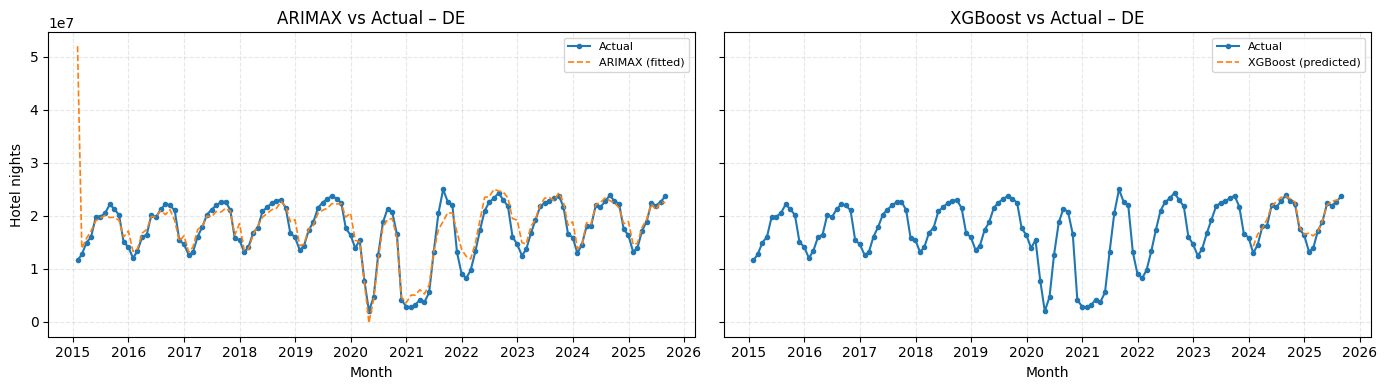

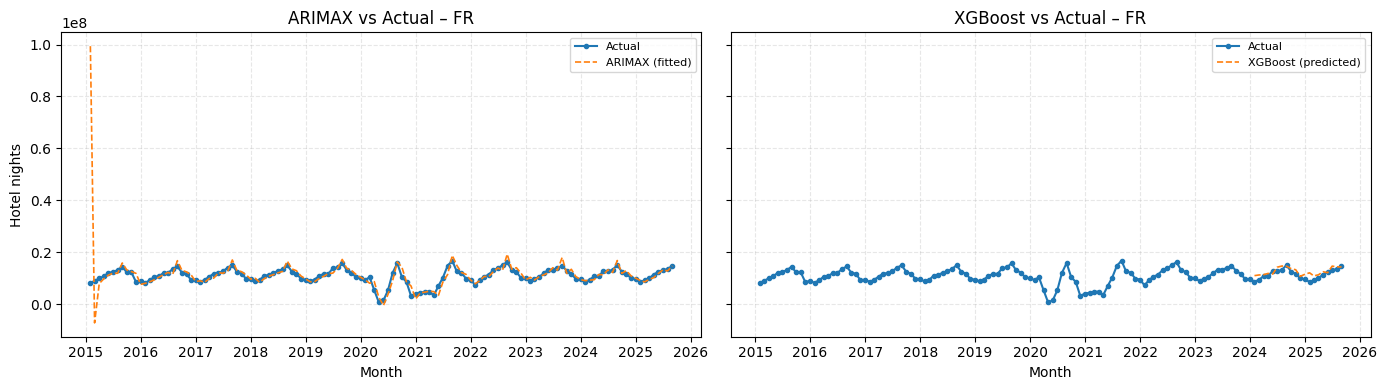

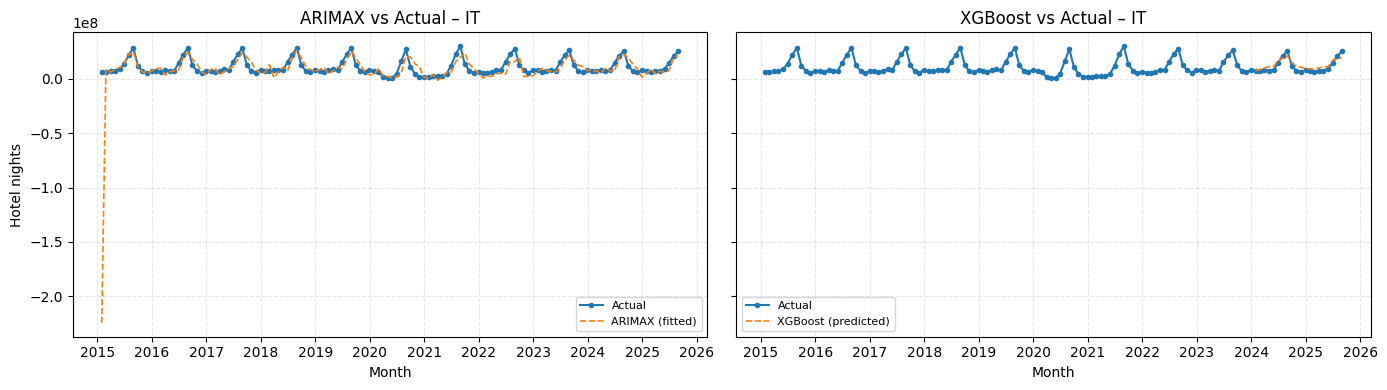

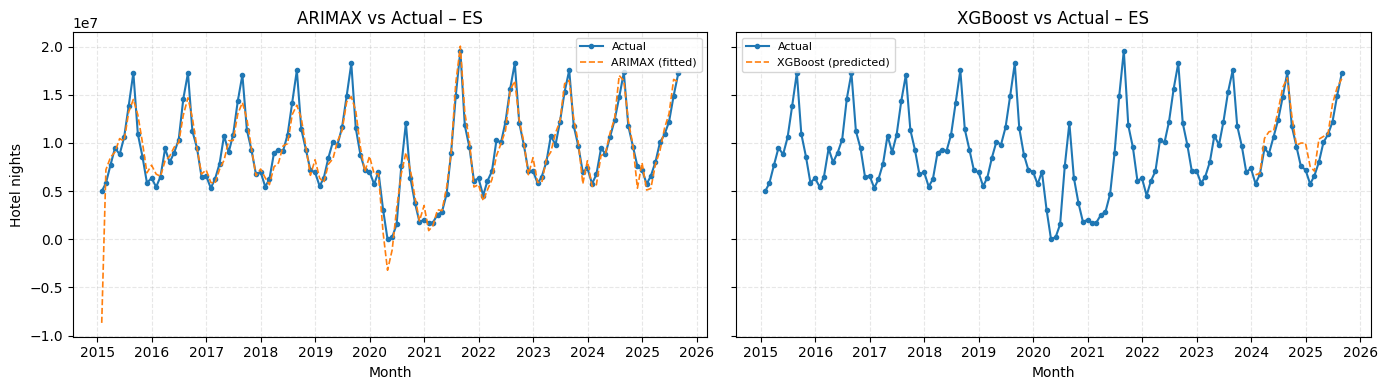

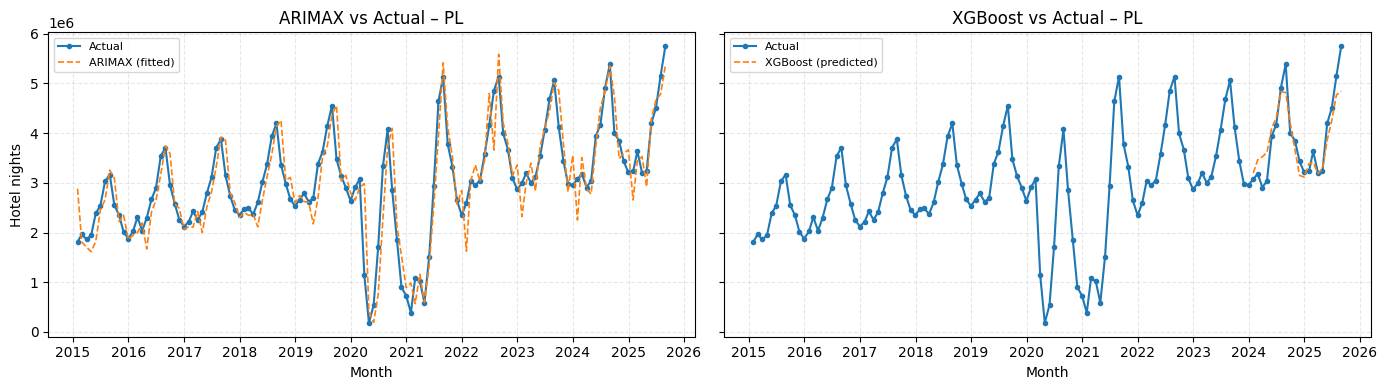

In [11]:
# %% -----------------------------------------------
# STEP 10 — ECONOMETRIC VS MACHINE LEARNING COMPARISON
# Purpose: Visual comparison of ARIMAX and XGBoost forecasts for top 5 EU countries.
# Output: outputs/figures/forecast_comparison_<country>.png
# -----------------------------------------------

plt.rcdefaults()

# --- Merge predictions back into main panel ---
df.loc[valid.index, "yhat_xgb"] = valid["yhat_xgb"]

# --- Define top 5 countries by average hotel demand ---
top_regions = (
    df.groupby("region")["nights_spent"]
    .mean()
    .nlargest(5)
    .index
)
print(f"[INFO] Evaluating top 5 regions: {list(top_regions)}")

# --- Plot for each country ---
for c in top_regions:
    subset = df.query("region == @c").sort_values("month")

    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    # --- Left plot: ARIMAX ---
    axes[0].plot(
        subset["month"], subset["nights_spent"],
        label="Actual", marker="o", markersize=3, lw=1.5
    )
    axes[0].plot(
        subset["month"], subset["yhat_arimax"],
        label="ARIMAX (fitted)", linestyle="--", lw=1.2
    )
    axes[0].set_title(f"ARIMAX vs Actual – {c}")
    axes[0].set_xlabel("Month")
    axes[0].set_ylabel("Hotel nights")
    axes[0].legend(fontsize=8)
    axes[0].grid(alpha=0.3, linestyle="--")
    axes[0].xaxis.set_major_locator(mdates.YearLocator())
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # --- Right plot: XGBoost ---
    axes[1].plot(
        subset["month"], subset["nights_spent"],
        label="Actual", marker="o", markersize=3, lw=1.5
    )
    axes[1].plot(
        subset["month"], subset["yhat_xgb"],
        label="XGBoost (predicted)", linestyle="--", lw=1.2
    )
    axes[1].set_title(f"XGBoost vs Actual – {c}")
    axes[1].set_xlabel("Month")
    axes[1].legend(fontsize=8)
    axes[1].grid(alpha=0.3, linestyle="--")
    axes[1].xaxis.set_major_locator(mdates.YearLocator())
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    plt.tight_layout()

    plt.show()

### 11. Export Predictions and Evaluation Tables

In [12]:
# %% -----------------------------------------------
# STEP 11 — EXPORT PREDICTIONS AND EVALUATION TABLES
# Purpose: Save full dataset with forecasts and model performance summaries.
# Outputs:
#   - outputs/processed/hotel_predictions.csv
#   - outputs/reports/base_model_metrics_summary.csv
# -----------------------------------------------

# --- Define export paths ---
PRED_PATH = DATA_PROCESSED / "hotel_predictions.csv"
EVAL_PATH = REPORTS / "base_model_metrics_summary.csv"

# --- Save data to files ---
df.to_csv(PRED_PATH, index=False)
eval_tbl.to_csv(EVAL_PATH, index=False)

# --- Confirmation messages ---
print("💾 Model outputs saved successfully:")
print(f"   • Predictions → {PRED_PATH.resolve()}")
print(f"   • Evaluation summary → {EVAL_PATH.resolve()}")

# --- Optional: quick verification ---
for path in [PRED_PATH, EVAL_PATH]:
    if path.exists():
        size_kb = path.stat().st_size / 1024
        print(f"✅ Verified: {path.name} ({size_kb:.1f} KB)")

💾 Model outputs saved successfully:
   • Predictions → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/data/processed/hotel_predictions.csv
   • Evaluation summary → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/reports/base_model_metrics_summary.csv
✅ Verified: hotel_predictions.csv (1497.7 KB)
✅ Verified: base_model_metrics_summary.csv (2.8 KB)


---

### 12. Insights and Next Steps

#### 🧾 Summary

This notebook built upon the cleaned and harmonized European hotel demand panel to perform feature engineering and develop forecasting models.

**Key steps:**
1. Created lagged and month-on-month features to capture temporal and macroeconomic dynamics.  
2. Added time indicators (month, quarter) and constructed a naïve baseline forecast.  
3. Trained and validated econometric (ARIMAX) and machine-learning (XGBoost) models at the country level.  
4. Compared model forecasts visually and quantitatively using RMSE and MAE metrics for the top 5 EU markets.  
5. Exported a feature-rich panel dataset for downstream modeling and interpretability analysis.

**Findings:**
- The **ARIMAX** model effectively captures autoregressive patterns and macroeconomic influences but adapts more slowly to rapid changes.  
- The **XGBoost** model achieves the **lowest average RMSE and MAE** across the top 5 countries, highlighting its strength in modeling nonlinear and cross-variable relationships.  
- Model performance varies by country, yet overall evidence suggests a robust and data-driven recovery signal across Europe’s major hotel markets.

**Next Steps → Notebook 3:**  
Proceed with econometric analysis and interpretability (e.g., fixed-effects regressions, feature importance, and SHAP) to explain drivers of hotel-demand recovery.

---
